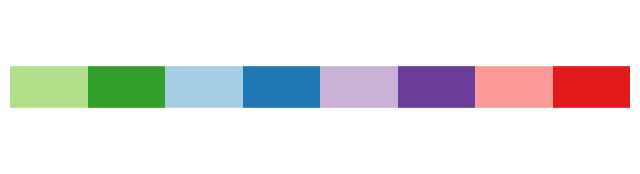

<IPython.core.display.Javascript object>

In [1]:
%load_ext nb_black
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import numpy as np
import os


def draw_colors(colors):
    # Plot the colors as swatches
    plt.figure(figsize=(8, 2))
    for i, color in enumerate(colors):
        plt.plot([i, i + 1], [0, 0], color=color, linewidth=30, solid_capstyle="butt")

    # Remove axes and set display limits
    plt.gca().axis("off")
    plt.xlim(0, len(colors))

    # Show the plot
    plt.show()


new_map = {
    "1, 1000": "#ffef33",
    "1, 10000": "#ff9924",
    "1, 50000": "#ff5d3d",
    "1, 100000": "#ff2176",
    "2, 1000": "#6fff5c",
    "2, 10000": "#4ffff0",
    "2, 50000": "#3ebbfa",
    "2, 100000": "#214eff",
}

new_map_v2 = {
    "16, 1": "#87fc60",
    "16, 2": "#2a7a0f",
    "32, 1": "#ffff4a",
    "32, 2": "#ebcb00",
    "64, 1": "#ff9326",
    "64, 2": "#bf5300",
    "128, 1": "#ff3b83",
    "128, 2": "#d60019",
}

paired = (
    sns.color_palette("Paired")[2:4]
    + sns.color_palette("Paired")[0:2]
    + sns.color_palette("Paired")[8:10]
    + sns.color_palette("Paired")[4:6]
)
new_map_v3 = {comb: paired[i] for i, comb in enumerate(new_map_v2.keys())}

# draw_colors(new_map.values())
# draw_colors(new_map_v2.values())
draw_colors(new_map_v3.values())

files = [
    "../../../data/out_metrics/results_20250121_174325_paramsize_0_24.pkl",
    "../../../data/out_metrics/results_20250122_043534_paramsize_24_32.pkl",
]


def savefig_and_show(figname):
    plt.savefig(figname + ".png", format="png", dpi=600)
    plt.savefig(figname + ".pdf", format="pdf")
    plt.show()


IMG_DIR = "../../img"

import matplotlib as mpl

mpl.rcParams["pdf.fonttype"] = 42

In [2]:
new_map_v2.keys()

dict_keys(['16, 1', '16, 2', '32, 1', '32, 2', '64, 1', '64, 2', '128, 1', '128, 2'])

<IPython.core.display.Javascript object>

In [3]:
all_results = dict()
for file_name in files:
    with open(file_name, "rb") as file:
        results = dict(pickle.load(file))
    all_results = {**all_results, **results}

print(f"Amount of sets: {len(all_results)}")

# Flatten the data while preserving the structure from the tuple keys
flattened_data = {
    "activation_function": [],
    "num_layers": [],
    "n_rows": [],
    "d_model": [],
    "iteration": [],
    "epochs": [],
    "accuracy": [],
    "capacity": [],
}

# Iterate over each dataset size, activation function, and number of layers
for (n_rows, act_fn, n_layers, d_model), list_of_iterations in all_results.items():
    # For each iteration in the dataset size
    for i, iteration_list in enumerate(list_of_iterations):
        # Flatten the iteration list with epochs multiplied by 2 (0, 2, 4, ..., 18)
        for epoch, value in enumerate(iteration_list):
            cur_act_fn = act_fn
            if act_fn == "default":
                cur_act_fn = "default"
            flattened_data["activation_function"].append(cur_act_fn)
            flattened_data["num_layers"].append(n_layers)
            flattened_data["n_rows"].append(n_rows)
            flattened_data["d_model"].append(d_model)
            flattened_data["iteration"].append(i)
            flattened_data["epochs"].append((epoch + 1) * 2)
            flattened_data["accuracy"].append(value)
            flattened_data["capacity"].append(int(value / 100 * n_rows))

# Convert to DataFrame for plotting
results_melted = pd.DataFrame(flattened_data)
results_melted.activation_function = results_melted.activation_function.apply(
    lambda x: {"default": "ReLU", "GELU": "GELU", "RAF": "RReLU", "softmax": "softmax"}[
        x
    ]
)
results_melted
# pd.DataFrame(all_results).T

Amount of sets: 32


,activation_function,num_layers,n_rows,d_model,iteration,epochs,accuracy,capacity
0,softmax,1,1000,16,0,2,0.000,0
1,softmax,1,1000,16,0,4,0.100,1
2,softmax,1,1000,16,0,6,1.200,12
3,softmax,1,1000,16,0,8,5.100,51
4,softmax,1,1000,16,0,10,8.400,84
...,...,...,...,...,...,...,...,...
23995,softmax,2,100000,128,2,492,88.283,88283
23996,softmax,2,100000,128,2,494,88.247,88247
23997,softmax,2,100000,128,2,496,88.298,88298
23998,softmax,2,100000,128,2,498,88.296,88296


<IPython.core.display.Javascript object>

In [4]:
def draw_acc_epochs(
    results_melted,
    cur_cutoff,
    layer_color_map,
    yticks=None,
    y_lines=None,  # Specific y level for horizontal line
    x="epochs",
    y="accuracy",
    xlabel="Epochs",
    ylabel="Accuracy, %",
    title="Mean accuracy with standard deviation per epoch of training\nfor different data sizes, model size, and layers amount",
):
    cur_results_melted = results_melted[results_melted.epochs <= cur_cutoff].rename(
        columns={
            "n_rows": "data size",
            "num_layers, n_rows": "layers amount, data size",
            "d_model": "model size",
        }
    )
    # Plot with Seaborn
    sns.set_style(
        "white",
        rc={
            "xtick.bottom": True,
            "ytick.left": True,
        },
    )

    plt.figure(figsize=(9, 5))

    if y_lines is not None:
        for y_line in y_lines:
            plt.axhline(
                y=y_line,
                color="black",
                alpha=0.7,
                linestyle="--",
                linewidth=0.5,  # Increase line width for emphasis
                #                 dashes=(10, 10), # Custom dash pattern: 10px dash, 10px gap
            )

    sns.lineplot(
        data=cur_results_melted,
        x=x,
        y=y,
        hue="layers amount, data size",  # Combined hue for Num_Layers and N_rows
        style="model size",
        size="model size",
        palette=layer_color_map,  # Ensure this supports the combined categories
        linewidth=1,
    )

    plt.xlim(0, cur_cutoff)

    # Add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc="upper left")
    sns.despine(offset=2)

    # Optionally add yticks
    if yticks is not None:
        plt.yticks(yticks)  # Custom y-ticks

    # Show the plot
    plt.tight_layout()
    plt.show()


def draw_acc_epochs_v2(
    results_melted,
    cur_cutoff,
    layer_color_map,
    yticks=None,
    y_lines=None,  # Specific y level for horizontal line
    x="epochs",
    y="accuracy",
    xlabel="Epochs",
    ylabel="Accuracy, %",
    title="Mean accuracy with standard deviation per epoch of training\nfor different data sizes, model size, and layers amount",
):
    cur_results_melted = results_melted[results_melted.epochs <= cur_cutoff].rename(
        columns={
            "n_rows": "data size",
            "num_layers, d_model": "model size, number of layers",
            "d_model": "model size",
        }
    )
    # Plot with Seaborn
    sns.set_style(
        "white",
        rc={
            "xtick.bottom": True,
            "ytick.left": True,
        },
    )

    plt.figure(figsize=(9, 5))

    if y_lines is not None:
        for y_line in y_lines:
            plt.axhline(
                y=y_line,
                color="black",
                alpha=0.9,
                linestyle="--",
                linewidth=0.9,  # Increase line width for emphasis
                #                 dashes=(10, 10), # Custom dash pattern: 10px dash, 10px gap
            )

    sns.lineplot(
        data=cur_results_melted,
        x=x,
        y=y,
        hue="model size, number of layers",  # Combined hue for Num_Layers and N_rows
        style="data size",
        size="data size",
        palette=layer_color_map,  # Ensure this supports the combined categories
        linewidth=1,
    )

    plt.xlim(0, cur_cutoff)

    # Add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Experiment 3:", bbox_to_anchor=(1.05, 1), loc="upper left")
    sns.despine(offset=2)

    # Optionally add yticks
    if yticks is not None:
        plt.yticks(yticks)  # Custom y-ticks

    # Show the plot
    plt.tight_layout()

<IPython.core.display.Javascript object>

In [5]:
# Generate unique colors for each Num_Layers value
# unique_layers = results_melted['num_layers'].unique()
# layer_palette = sns.color_palette("Set2", len(unique_layers))
# layer_color_map = {layer: color for layer, color in zip(unique_layers, layer_palette)}

results_melted['num_layers, n_rows'] = results_melted['num_layers'].astype(str) + ", " + results_melted['n_rows'].astype(str)  
results_melted['num_layers, d_model'] = results_melted['d_model'].astype(str) + ", " + results_melted['num_layers'].astype(str)  
# unique_hues = sorted(results_melted['n_rows, num_layers'].unique())
# layer_color_map = {hue: sns.color_palette("Paired")[i % 10] for i, hue in enumerate(unique_hues)}


<IPython.core.display.Javascript object>

50


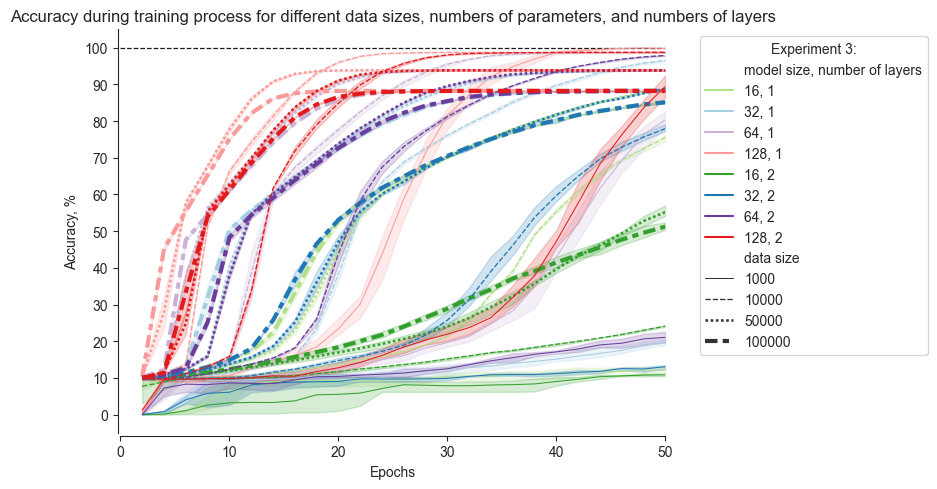

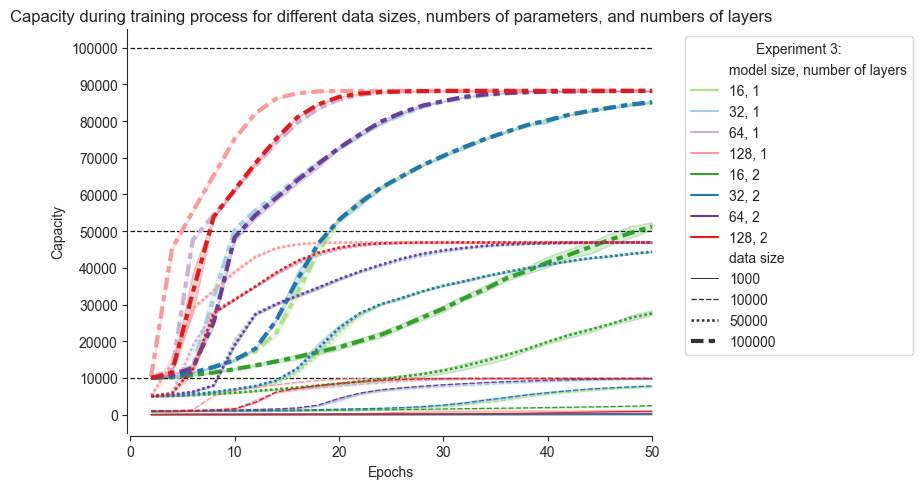

100


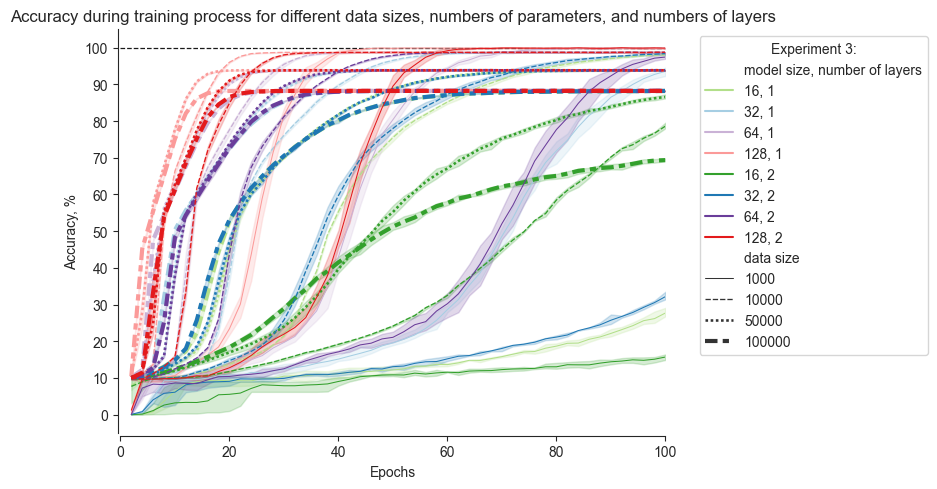

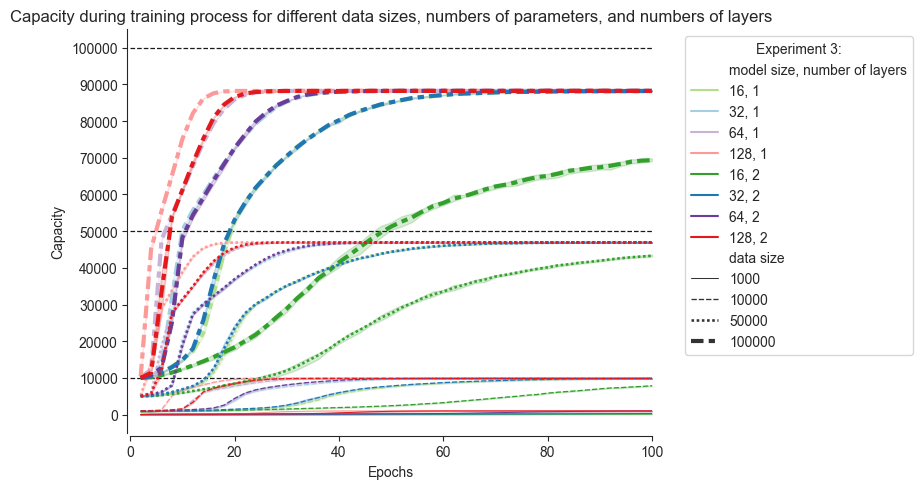

500


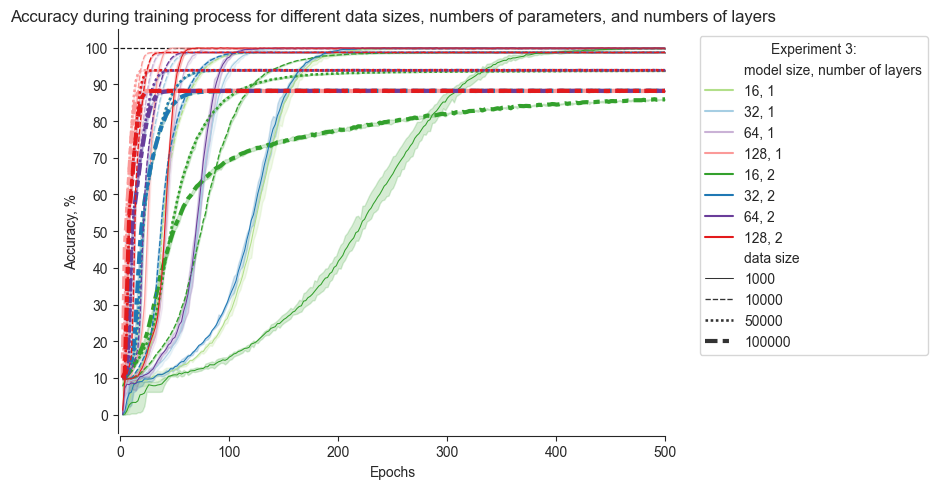

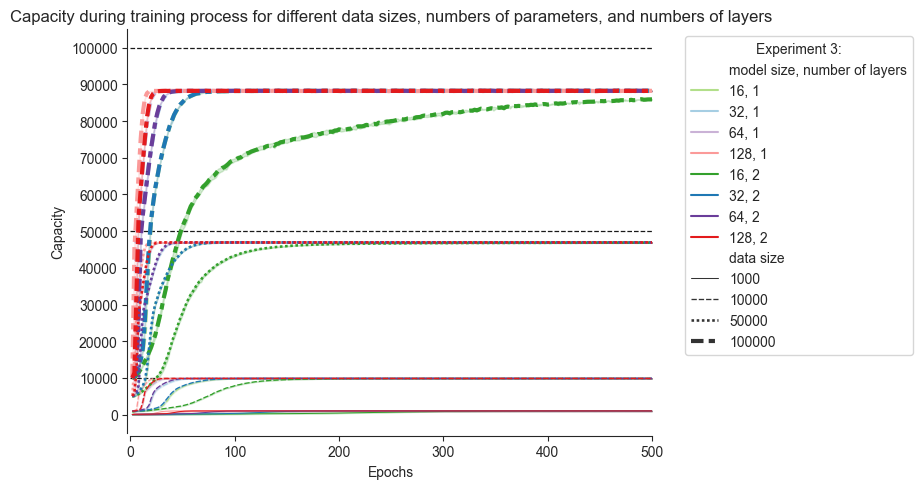

<IPython.core.display.Javascript object>

In [6]:
for epochs in [50, 100, results_melted.epochs.max()]:
    print(epochs)
    draw_acc_epochs_v2(
        results_melted,
        epochs,
        new_map_v3,
        yticks=np.arange(0, 101, 10),
        y_lines=[
            100,
        ],
        x="epochs",
        y="accuracy",
        xlabel="Epochs",
        ylabel="Accuracy, %",
        title="Accuracy during training process for different data sizes, numbers of parameters, and numbers of layers",
    )
    savefig_and_show(os.path.join(IMG_DIR, f"3_paramsize_acc_{epochs}"))
    draw_acc_epochs_v2(
        results_melted,
        epochs,
        new_map_v3,
        yticks=np.arange(0, 100001, 10000),
        y_lines=[10000, 50000, 100000],
        x="epochs",
        y="capacity",
        xlabel="Epochs",
        ylabel="Capacity",
        title="Capacity during training process for different data sizes, numbers of parameters, and numbers of layers",
    )
    savefig_and_show(os.path.join(IMG_DIR, f"3_paramsize_cap_{epochs}"))

## Violins

In [8]:
data_viol = results_melted[results_melted.epochs == max(results_melted.epochs)]
data_viol.head()

,activation_function,num_layers,n_rows,d_model,iteration,epochs,accuracy,capacity,"num_layers, n_rows","num_layers, d_model"
249,softmax,1,1000,16,0,500,100.0,1000,"1, 1000","16, 1"
499,softmax,1,1000,16,1,500,100.0,1000,"1, 1000","16, 1"
749,softmax,1,1000,16,2,500,99.9,999,"1, 1000","16, 1"
999,softmax,1,1000,32,0,500,99.8,998,"1, 1000","32, 1"
1249,softmax,1,1000,32,1,500,100.0,1000,"1, 1000","32, 1"


In [10]:
temp = deepcopy(data_viol)
temp.d_model = 'all'


df = pd.concat([data_viol, temp]).set_index(['d_model','num_layers'])[['n_rows', 'accuracy', 'capacity']]
display(df)
grouped = (
    df.groupby(['d_model', 'num_layers', 'n_rows'])
    .agg(accuracy_mean=('accuracy', 'mean'),
         accuracy_std=('accuracy', 'std'),
         capacity_mean=('capacity', 'mean'),
         capacity_std=('capacity', 'std'))
)

# Unstack to pivot `n_rows` into columns
final = grouped.unstack(level='n_rows')

# Create a MultiIndex for columns with the correct order
final.columns = pd.MultiIndex.from_tuples(
    [(n_rows, metric) for metric, n_rows in final.columns],
    names=["n_rows", "metric"]
)
# ORDER cols
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]

# ORDER rows
# Define the desired order for 'activation_function'
activation_order = [16, 32, 64, 128, 'all']

# Reorder rows based on the activation function order
final = final.loc[activation_order]

# Rearrange columns: first all related to 50000, then 70000
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]


final.round(2)

n_rows  accuracy  capacity
d_model num_layers                            
16      1             1000   100.000      1000
        1             1000   100.000      1000
        1             1000    99.900       999
32      1             1000    99.800       998
        1             1000   100.000      1000
...                    ...       ...       ...
all     2           100000    88.211     88211
        2           100000    88.268     88268
        2           100000    88.230     88230
        2           100000    88.184     88184
        2           100000    88.229     88229

[192 rows x 3 columns]

n_rows                    1000                                            \
metric             accuracy_mean accuracy_std capacity_mean capacity_std   
d_model num_layers                                                         
16      1                  99.97         0.06        999.67         0.58   
        2                  99.83         0.15        998.33         1.53   
32      1                  99.83         0.15        998.33         1.53   
        2                  99.87         0.15        998.67         1.53   
64      1                  99.90         0.10        999.00         1.00   
        2                  99.87         0.15        998.67         1.53   
128     1                  99.90         0.10        999.00         1.00   
        2                  99.87         0.15        998.67         1.53   
all     1                  99.90         0.10        999.00         1.04   
        2                  99.86         0.13        998.58         1.31   

n_rows                    10000                                           \
metric             accuracy_mean accuracy_std capacity_mean capacity_std   
d_model num_layers                                                         
16      1                  98.70         0.05       9870.33         5.13   
        2                  98.75         0.02       9874.67         2.08   
32      1                  98.72         0.06       9872.00         5.57   
        2                  98.76         0.04       9876.00         4.36   
64      1                  98.78         0.05       9878.33         4.51   
        2                  98.76         0.04       9876.00         3.61   
128     1                  98.77         0.06       9876.67         6.11   
        2                  98.72         0.03       9872.00         3.00   
all     1                  98.74         0.06       9874.33         5.71   
        2                  98.75         0.03       9874.67         3.34   

n_rows                    50000                                           \
metric             accuracy_mean accuracy_std capacity_mean capacity_std   
d_model num_layers                                                         
16      1                  93.87         0.15      46937.33        73.91   
        2                  93.72         0.09      46857.67        46.26   
32      1                  93.91         0.12      46955.33        59.34   
        2                  93.85         0.13      46927.00        63.91   
64      1                  93.86         0.12      46932.00        61.10   
        2                  93.84         0.10      46919.33        47.82   
128     1                  93.86         0.08      46929.67        42.72   
        2                  93.88         0.13      46938.00        65.64   
all     1                  93.88         0.10      46938.58        52.48   
        2                  93.82         0.12      46910.50        58.26   

n_rows                    100000                                          
metric             accuracy_mean accuracy_std capacity_mean capacity_std  
d_model num_layers                                                        
16      1                  88.24         0.04      88236.33        36.75  
        2                  85.94         0.08      85935.00        76.33  
32      1                  88.23         0.03      88234.33        30.75  
        2                  88.25         0.04      88252.33        41.10  
64      1                  88.24         0.05      88242.00        50.86  
        2                  88.24         0.03      88237.00        28.83  
128     1                  88.25         0.01      88248.33        14.57  
        2                  88.21         0.03      88214.33        26.27  
all     1                  88.24         0.03      88240.25        30.96  
        2                  87.66         1.04      87659.67      1040.90

In [ ]:
def draw_violins(
    data_viol, 
    x, 
    y, 
    xlabel, 
    ylabel, 
    title, 
    yticks=None, 
    hue=None, 
    return_ax=False, 
    ax=None
):
    PALETTE_PARAMS = "Accent"
    PALETTE = "Set2"
    data_dict = {
        "x": x,
        "y": y,
        "palette": list(new_map.values())[3::4],
        "linewidth": 0.5,
    }
    if hue:
        data_dict["hue"] = hue
        data_dict["dodge"] = True
    if ax:
        data_dict["ax"] = axs[col]
        
        
    sns.set_style("white", rc={
        'xtick.bottom': True,
        'ytick.left': True,
    })
    ax = sns.violinplot(
        data_viol,
        **data_dict,
        cut=0,
        legend=False,
        scale="count", 
        alpha=0.3
    )
    plt.setp(ax.collections, alpha=0.6)
    ax = sns.stripplot(data_viol, **data_dict, legend=True, alpha=0.9)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    sns.despine(offset=2)
    # Optionally add yticks
    if yticks is not None:
        ax.set_yticks(yticks)  # Custom y-ticks
    if return_ax:
        return ax

In [ ]:
int(data_viol.accuracy.min())

In [ ]:
labels = [
    (
        "accuracy",
        "Accuracy, %",
        "Accuracy by layers amount for all model size.",
        "Accuracy by layers amount for different model sizes",
        np.arange(85, 101, 1)
    ),
    (
        "capacity",
        "Capacity",
        "Capacity by layers amount for all model size.",
        "Capacity by layers amount for different model size",
        np.arange(0, 100001, 10000)
    ),
]


for y, ylabel, title, title_separated, val_range in labels:
    print("All together")
    plt.figure(figsize=(12, 6))
    draw_violins(
        data_viol,
        x="n_rows",
        y=y,
        xlabel="Layers amount",
        ylabel=ylabel,
        title=title,
        hue="num_layers",
        yticks=val_range
    )
    plt.show()
    # ==================================================
    print("Separated")
    sns.set(rc={"figure.figsize": (14, 4)})
    # get legend
    ax = draw_violins(
        data_viol,
        x="n_rows",
        y=y,
        xlabel="Layers amount",
        ylabel=ylabel,
        title=title_separated,
        hue="num_layers",
        return_ax=True,
        yticks=val_range
    )
    handles, labels = ax.get_legend_handles_labels()
    plt.clf()
    # draw
    fig, axs = plt.subplots(nrows=1, ncols=4)
    for i, act_f in enumerate(data_viol.d_model.unique()):
        row = i // 4
        col = i % 4
        cur_data = data_viol[data_viol.d_model == act_f]
        ax = draw_violins(
            cur_data,
            x="n_rows",
            y=y,
            xlabel="Layers amount",
            ylabel=ylabel,
            title=f"`{act_f}`.",
            hue="num_layers",
            return_ax=True,
            ax=axs[col],
            yticks=val_range
        )
#         plt.setp(ax.collections, alpha=0.58)
        ax.legend_.remove()
        ax.set(ylabel="", xlabel="", title=act_f)
        ax.set(ylim=(min(val_range), max(val_range)))
        ax
    fig.supylabel(ylabel, y=0.5, x=0.08)
    fig.supxlabel("Data size", y=0, x=0.5)
    fig.suptitle(title_separated, y=1, x=0.5)
    fig.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.9, 0.5),
        title="Layers amount",
    )
    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2
    )
    plt.show()